# Face verification app

### Goal statement: Build an app that will be able to verify the user's face by distinguishing it from other faces.

### Methodology followed: 
####  1. Build a dataset by using local camera and taking snapshots. We need positive pairs of pictures (where both pictures belong to the same face) and negative pairs (for this, we have used the Labelled Faces in the Wild dataset). 
#### For this reason we create three directories, the first is the Anchor (first images in the pairs), the second is the Positive (second images in the pairs that match the anchors) and the third is the Negative directory (third images in the pairs that differentiate from the anchors).

__Import dependencies:__

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf 
import os
import cv2
import random
import numpy as np
from matplotlib import pyplot as plt
import uuid

__Verify that GPU is configured with Tensorflow:__

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.test.is_gpu_available(cuda_only=False,min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
 tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

__Create directories to save the samples:__

In [3]:
# Setup Paths
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data', 'anchor')
VER_PATH = os.path.join('application_data', 'verification_images')
INP_PATH = os.path.join('application_data', 'input_image')

In [7]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)
os.makedirs(VER_PATH)
os.makedirs(INP_PATH)

__Uncompress the Labelled Faces in the Wild dataset and move them to /data/negative path:__

In [8]:
!tar -xf lfw.tgz

In [9]:
# Move LFW images to data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

__Use OpenCV to establish connection to the webcam and take pictures. The frame must be cropped to be 250x250 end keyboard actions must be specified in order to save the pictures in the corresponding folders and break gracefully:__

In [57]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    # Resize frame to 250x250 px
    frame = frame[190:190+250, 230:230+250, :]
    
    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)     

    # Collect verifications
    if cv2.waitKey(1) & 0XFF == ord('v'):
        imgname = os.path.join(VER_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam        
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

__Function to insert random noise (brightness, contrast, flip, jpeg_quality, saturation) to pictures that have been captured by the webcam, so that more samples are created and the model is able to generalize better:__

In [62]:
def data_augmentation(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100), np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9, upper=1, seed=(np.random.randint(100),np.random.randint(100)))
        
        data.append(img)
        
    return data

__Apply the data augmentation function to the whole Anchor and Positive directories:__

In [64]:
def apply_data_augmentation(file_path):
    for file_name in os.listdir(os.path.join(file_path)):
        img_path = os.path.join(file_path, file_name)
        img = cv2.imread(img_path)
        augmented_images = data_augmentation(img)

        for image in augmented_images:
            cv2.imwrite(os.path.join(file_path, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [65]:
apply_data_augmentation(ANC_PATH)
apply_data_augmentation(POS_PATH)

__Take 3000 sample file paths in a random shuffled manner from each directory:__

In [6]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

__Define function to load images from filepaths, decode jpegs, scale pixel values to facilitate training and resize images to 105x105 (input dimension for our conv layer):__

In [7]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (105,105))
    img = img / 255.0
    return img

__Create labeled dataset with pairs of positives, negatives and labels (1,0)__

In [8]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

__Define function to preprocess the sample pairs:__

In [9]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

__Build dataloader pipeline to apply the preprocessing process, cache the dataset and shuffle in order to have both positive and negative pairs in training and testing sets:__

In [10]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

__Split dataset to training and testing at 0.7, create batches of 16 and prefetch to improve latency and throughput:__

In [11]:
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [12]:
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16, drop_remainder =True)
test_data = test_data.prefetch(8)

__Build the embedding layer:__

In [13]:
def make_embedding():
    inp = Input(shape=(105,105,3), name='input_image')
    
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [14]:
embedding = make_embedding()

__Description of the embedding layer:__

In [56]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

__Defining class of custom layer for L1 Distance between the embeddings:__

In [15]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
        
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

__Build the final siamese network model so as to process the pairs of images, calculate the L1 distance and do the binary classification:__

In [16]:
def make_siamese_model():
    
    # Handle inputs
    input_image = Input(name='input_img', shape=(105,105,3))
    validation_image = Input(name='validaption_img', shape=(105,105,3))
    
    
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification Layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='siamese_network')

In [17]:
siamese_model = make_siamese_model()

__Define Loss and optimizer:__

In [18]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(0.0001)

__Create checkpoints for the training:__

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

__Define the training step process, by using the GradientTape.gradient and the apply_gradients(). Convert it to a graph representation for better performance:__

In [22]:
@tf.function
def train_step(batch):
    
    # Record all operations
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
            
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

__Training process to loop through the batches, perform the training step and accumulate statistics for the precision and recall for each epoch:__

In [23]:
def train(data, EPOCHS):
    # loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch,EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2], verbose=0)
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
            
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        

In [24]:
EPOCHS = 20

In [25]:
train(train_data, EPOCHS)


 Epoch 1/20
263/263 [==============================] - 222s 809ms/step
0.06235489 0.89133555 0.9607843

 Epoch 2/20
263/263 [==============================] - 202s 767ms/step
0.21617629 0.9517958 0.96920115

 Epoch 3/20
263/263 [==============================] - 216s 822ms/step
0.07235437 0.9665698 0.97938144

 Epoch 4/20
263/263 [==============================] - 201s 763ms/step
0.03273231 0.97424895 0.98647994

 Epoch 5/20
263/263 [==============================] - 190s 721ms/step
0.04487867 0.9788766 0.9902865

 Epoch 6/20
263/263 [==============================] - 189s 718ms/step
0.0014747131 0.98517454 0.98895824

 Epoch 7/20
263/263 [==============================] - 189s 720ms/step
0.0262644 0.9804296 0.9898795

 Epoch 8/20
263/263 [==============================] - 189s 719ms/step
0.025025636 0.9929044 0.992435

 Epoch 9/20
263/263 [==============================] - 191s 726ms/step
0.0018410843 0.9895288 0.99094373

 Epoch 10/20
263/263 [==============================] - 193s 

__Evaluate the model on the testing set:__

In [64]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val], verbose=0)
    r.update_state(y_true, yhat)
    p.update_state(y_true, yhat)

print(r.result().numpy(), p.result().numpy())

0.9988479 0.984109


__Visualize the data:__

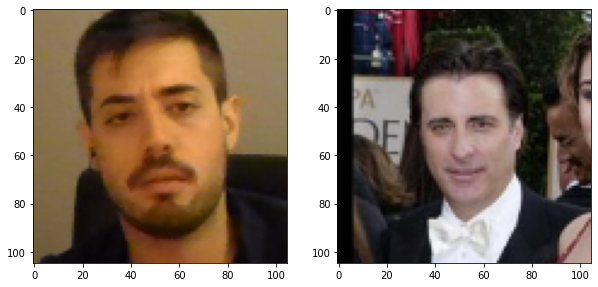

0.0


In [68]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[9])
plt.subplot(1,2,2)
plt.imshow(test_val[9])
plt.show()
print(y_true[9])

__Save the model:__

In [52]:
siamese_model.save('siamesemodel_v1.h5')

In [53]:
model = tf.keras.models.load_model('siamesemodel_v1.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [54]:
model.predict([test_input, test_val])

1/1 [==============================] - 0s 95ms/step


array([[9.9166942e-01],
       [9.9996448e-01],
       [9.3885928e-01],
       [3.6142524e-08],
       [2.5491684e-03],
       [2.2878610e-03],
       [5.4259185e-04],
       [1.4850105e-05],
       [2.3971131e-04],
       [9.9927801e-01],
       [9.9973983e-01],
       [2.6799130e-04],
       [8.5690004e-08],
       [9.9219513e-01],
       [9.9998927e-01],
       [9.9985564e-01]], dtype=float32)

In [55]:
model.summary()

Model: "siamese_network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validaption_img (InputLayer)   [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validaption_img[0

__Verification function - Compare the input image with each one of the verification images. If the number of images that have been predicted as positive (p>detection_threshold) is greater than the verification_threshold, then the person is verified:__

In [50]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
       
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold
    
    return results, verified

__Use the webcam to capture a photo as an input for the verification:__

In [63]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[190:190+250, 230:230+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
    
        results, verified = verify(model, 0.5, 0.5)
        print(verified)
        
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()